In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import pickle
import sqlalchemy as sa
import datetime as dtt
import calendar
from fbprophet import Prophet

In [2]:
### GLOBAL VARS ###
connstr = 'enter connection string for RS'
engine = sa.create_engine(connstr, connect_args={'sslmode': 'verify-ca'})

In [3]:
#load data
with engine.connect() as conn, conn.begin():
    df = pd.read_sql(sa.text(""" SELECT
	DATE(CONVERT_TIMEZONE('UTC', 'America/Chicago', call_data_ordinals.call_created_at )) AS "date_call",
	DATE_PART(hour, CONVERT_TIMEZONE('UTC', 'America/Chicago', call_data_ordinals.call_created_at ))::integer AS "hour_call",
	COUNT(DISTINCT call_data_ordinals.call_id ) AS "ib_attempts"
FROM looker_scratch.LR$J7M8H1583946728208_call_data_ordinals AS call_data_ordinals

WHERE ((call_data_ordinals.call_created_at  >= CONVERT_TIMEZONE('America/Chicago', 'UTC', TIMESTAMP '2018-01-01')))
AND (((CASE WHEN call_data_ordinals.call_type = 1 THEN 'Inbound' ELSE 'Outbound' END) ILIKE 'Inbound')) 
AND (call_data_ordinals.tenant_name NOT ILIKE 'Veritas Prep' OR call_data_ordinals.tenant_name IS NULL) 
AND (CASE WHEN call_data_ordinals.contact_id IS NOT NULL THEN call_data_ordinals.attempt_ordinal ELSE NULL END  > 1) 
AND (call_data_ordinals.tag_name NOT ILIKE 'music' AND call_data_ordinals.tag_name NOT ILIKE 'international' AND call_data_ordinals.tag_name NOT ILIKE 'prof certifications' AND call_data_ordinals.tag_name NOT ILIKE 'international ROW' AND call_data_ordinals.tag_name NOT ILIKE 'VP-Main' AND call_data_ordinals.tag_name NOT ILIKE 'VP-AdCon' AND call_data_ordinals.tag_name NOT ILIKE 'VP-International' AND call_data_ordinals.tag_name NOT ILIKE 'Free SAT/ACT' OR call_data_ordinals.tag_name IS NULL)
GROUP BY 1,2
ORDER BY 1 DESC"""), conn)

In [4]:
df.isnull().sum()

date_call      0
hour_call      0
ib_attempts    0
dtype: int64

In [5]:
df.date_call = pd.to_datetime(df.date_call)
df.date_call = df.date_call + pd.to_timedelta(df.hour_call,unit='hr')
df.date_call = df.date_call.dt.strftime('%Y-%m-%d %H:%M:%S')
df.date_call = pd.to_datetime(df.date_call)

In [6]:
df.head()

,date_call,hour_call,ib_attempts
0,2020-03-11 01:00:00,1,1
1,2020-03-11 07:00:00,7,14
2,2020-03-11 04:00:00,4,1
3,2020-03-11 11:00:00,11,53
4,2020-03-11 06:00:00,6,2


In [7]:
df_master = df.copy()

# Hourly forecast

In [8]:
df = df[df.date_call < '2020-03-01 00:00:00'].sort_values(by='date_call' , ascending = False).reset_index(drop=True)

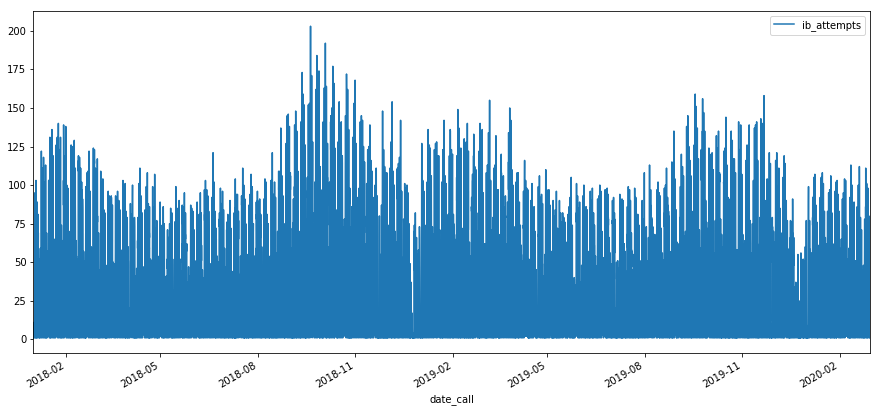

In [9]:
df.plot(x = 'date_call' , y= 'ib_attempts' , kind='line', figsize = (15,7))

In [10]:
# creating the log transform version 
df_mod = df[['date_call' , 'ib_attempts']]
df_mod.columns = ['ds' , 'y']
df_mod['y'] = np.where(df_mod['y']>0, np.log(df_mod['y']), 0)

C:\Users\Dhananjai Gaur\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


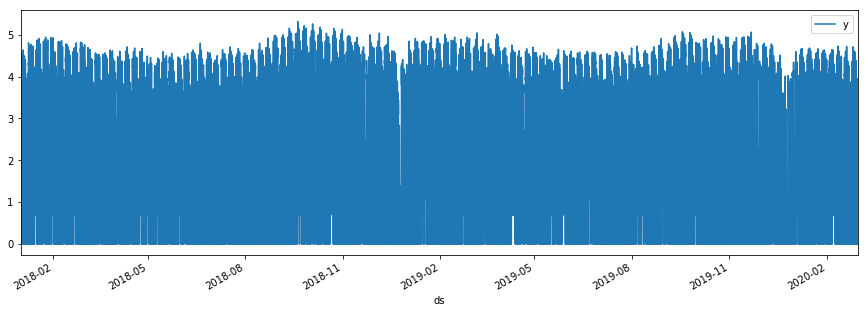

In [11]:
df_mod.plot(x = 'ds' , y= 'y' , kind='line', figsize = (15,5))

In [12]:
model = Prophet(seasonality_mode='multiplicative' 
                    , yearly_seasonality = True
                    , weekly_seasonality = True
                    , daily_seasonality = True)

model.fit(df_mod)

C:\Users\Dhananjai Gaur\Anaconda3\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
C:\Users\Dhananjai Gaur\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [13]:
future_periods = model.make_future_dataframe(periods=268, freq='H')
forecast = model.predict(future_periods)

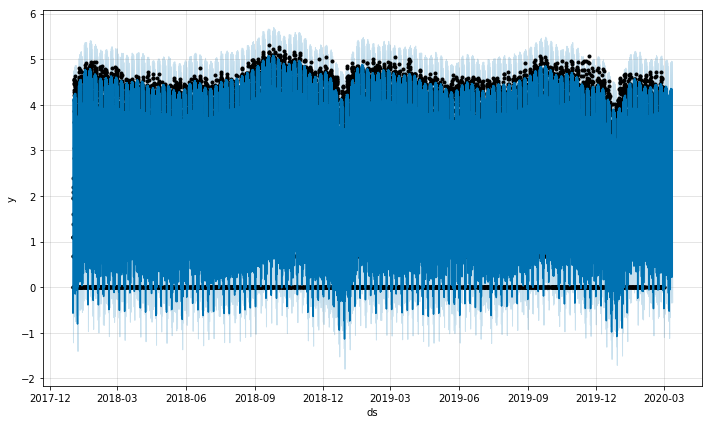

In [14]:
model.plot(forecast);

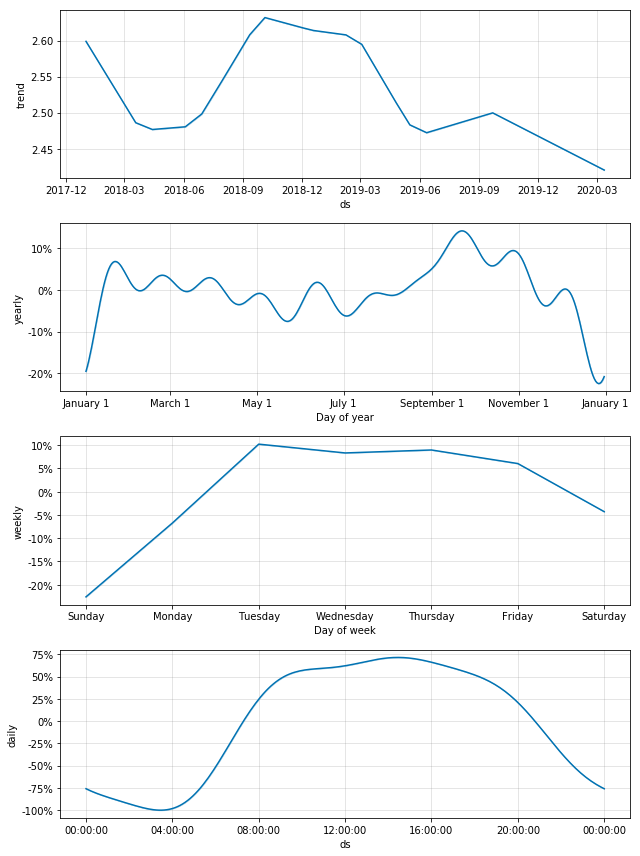

In [15]:
model.plot_components(forecast);

In [16]:
fcst_final = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
fcst_final['yhat_lower'] =  np.ceil(np.exp(fcst_final['yhat_lower']))
fcst_final['yhat'] =  np.ceil(np.exp(fcst_final['yhat']))
fcst_final['yhat_upper'] =  np.ceil(np.exp(fcst_final['yhat_upper']))

C:\Users\Dhananjai Gaur\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Dhananjai Gaur\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Dhananjai Gaur\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

In [17]:
fcst_final['yhat_lower'] =  np.where(fcst_final.yhat_lower<0 , 0 , np.ceil(fcst_final.yhat_lower))
fcst_final['yhat'] =  np.where(fcst_final.yhat<0 , 0 , np.ceil(fcst_final.yhat))
fcst_final['yhat_upper'] =  np.where(fcst_final.yhat_upper<0 , 0 , np.ceil(fcst_final.yhat_upper))

C:\Users\Dhananjai Gaur\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Dhananjai Gaur\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Dhananjai Gaur\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

In [30]:
df_merged_hourly = pd.merge(fcst_final[fcst_final.ds.dt.date >= np.datetime64('2020-03-08')][['ds' , 'yhat']]
                     , df_master[df_master.date_call.dt.date >= np.datetime64('2020-03-08')].sort_values(by='date_call' , ascending = True).reset_index(drop=True)
                     , left_on = 'ds' 
                     , right_on = 'date_call'
                     , how='left')
df_merged_hourly['hour_call'] = df_merged_hourly.ds.dt.hour

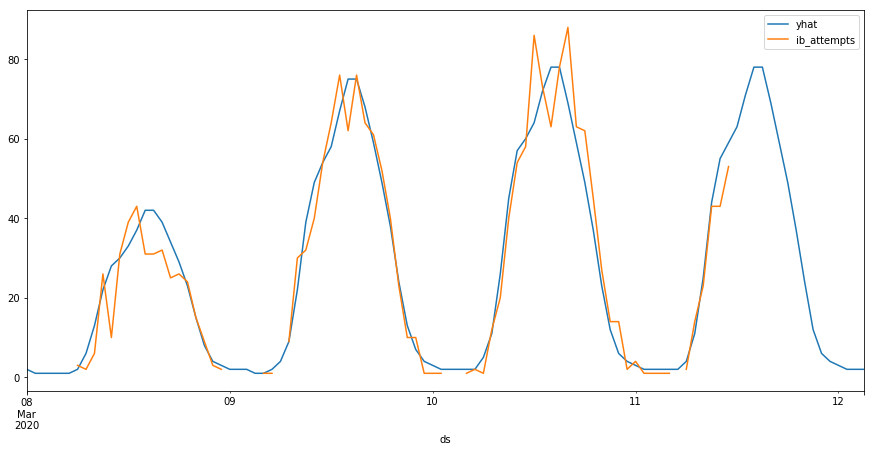

In [32]:
# this is the comparison for forecast and actuals - 
# 'yhat' is the forecast ; 
# ib_attempts is the actual
# Hour of the day in CST
df_merged_hourly.plot(x = 'ds' , y= ['yhat','ib_attempts'] , kind='line', figsize = (15,7))#[['ds','yhat','ib_attempts']]

# Daily forecast

In [93]:
df_daily = df_master.copy()
df_daily['date'] = pd.to_datetime(df_daily.date_call.dt.date)

In [94]:
df_final = df_daily.groupby(['date'])[['ib_attempts']].sum().reset_index()
df_final = df_final[(df_final.date <'2020-03-01')].sort_values(by='date' , ascending = False).reset_index(drop=True)

In [95]:
df_final.head()

,date,ib_attempts
0,2020-02-29,437
1,2020-02-28,693
2,2020-02-27,851
3,2020-02-26,890
4,2020-02-25,881


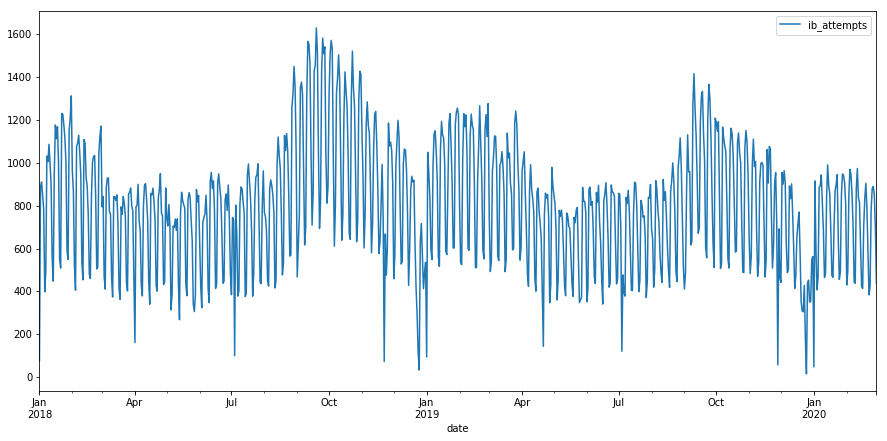

In [96]:
df_final.plot(x = 'date' , y= 'ib_attempts' , kind='line', figsize = (15,7))

In [97]:
# creating the log transform version 
df_mod = df_final[['date' , 'ib_attempts']]
df_mod.columns = ['ds' , 'y']
df_mod['y'] = np.where(df_mod['y']>0, np.log(df_mod['y']), 0)

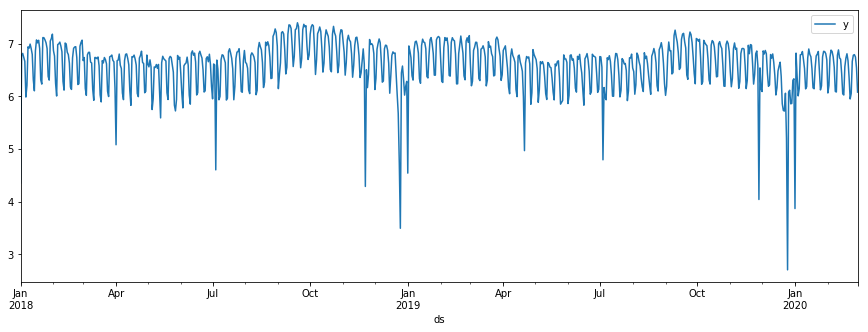

In [98]:
df_mod.plot(x = 'ds' , y= 'y' , kind='line', figsize = (15,5))

In [99]:
model = Prophet(seasonality_mode='multiplicative' 
                    , yearly_seasonality = True
                    , weekly_seasonality = True)
#model.add_seasonality(name='monthly', period=30.5, fourier_order=15)
model.fit(df_mod)

C:\Users\Dhananjai Gaur\Anaconda3\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\Dhananjai Gaur\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [100]:
future_periods = model.make_future_dataframe(periods=30, freq='D')
forecast = model.predict(future_periods)

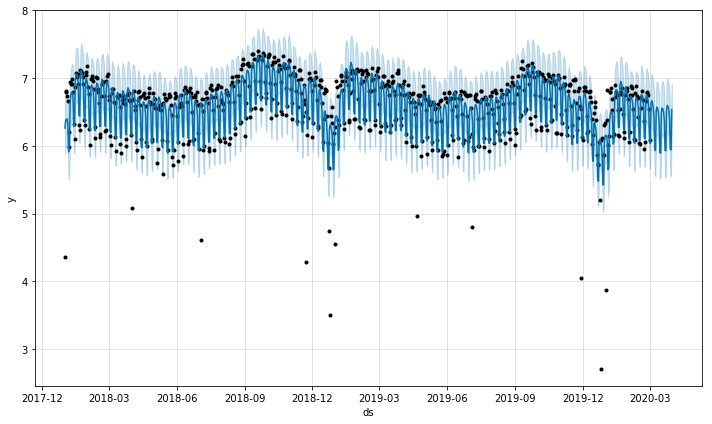

In [101]:
model.plot(forecast);

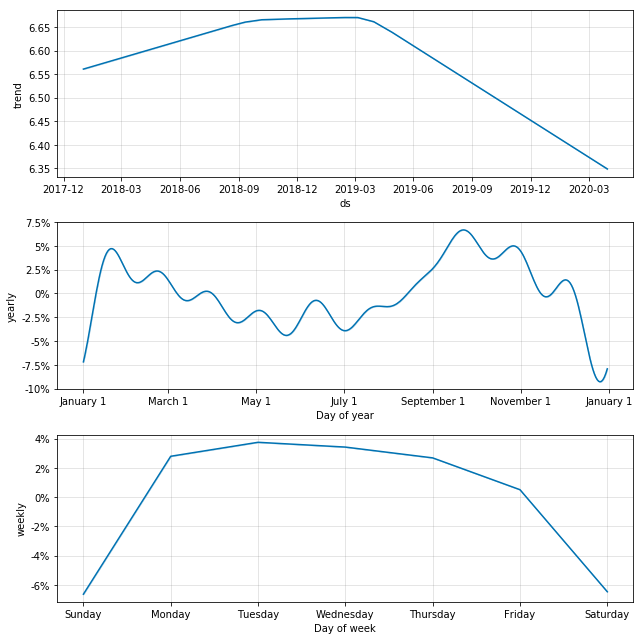

In [102]:
model.plot_components(forecast);

In [103]:
fcst_final = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
fcst_final['yhat_lower'] =  np.ceil(np.exp(fcst_final['yhat_lower']))
fcst_final['yhat'] =  np.ceil(np.exp(fcst_final['yhat']))
fcst_final['yhat_upper'] =  np.ceil(np.exp(fcst_final['yhat_upper']))

C:\Users\Dhananjai Gaur\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Dhananjai Gaur\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Dhananjai Gaur\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

In [114]:
temp = df_daily.groupby(['date'])[['ib_attempts']].sum().reset_index()
df_merged = pd.merge(fcst_final[fcst_final.ds.dt.date >= np.datetime64('2020-03-01')][['ds' , 'yhat']] 
                     , temp[(temp.date>= np.datetime64('2020-03-01')) & (temp.date<= np.datetime64('2020-03-10'))]
                     , left_on = 'ds' 
                     , right_on = 'date'
                     , how='left')

In [117]:
# this is the comparison for forecast and actuals - 
# 'yhat' is the forecast ; 
# ib_attempts is the actual

df_merged[['ds','yhat','ib_attempts']]

,ds,yhat,ib_attempts
0,2020-03-01,418.0,455.0
1,2020-03-02,751.0,778.0
2,2020-03-03,785.0,828.0
3,2020-03-04,757.0,858.0
4,2020-03-05,711.0,765.0
5,2020-03-06,610.0,511.0
6,2020-03-07,386.0,348.0
7,2020-03-08,377.0,360.0
8,2020-03-09,679.0,706.0
9,2020-03-10,714.0,805.0


In [119]:
df_merged[['ds','yhat']].to_csv('forecast_IBs_0320.csv' , index = False)